In [2]:
import os
import ast
import pandas as pd
from langchain import LLMChain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains.mapreduce import MapReduceChain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import (
                StuffDocumentsChain,
                LLMChain,
                ReduceDocumentsChain,
                MapReduceDocumentsChain,
            )

### Preprocess

Get the first question per chat.

In [4]:
# Read
d=pd.read_csv("data/langchain_data_may15_may30.csv")

# List
d['messages_unpack'] = d['messages'].apply(lambda x: ast.literal_eval(x))
d['messages_first'] = d['messages_unpack'].apply(lambda x: x[0])

# Flatten the list of lists and convert to lowercase
combined_messages = [msg.lower() for sublist in d['messages_unpack'] for msg in sublist]
first_messages = [msg.lower() for msg in d['messages_first']]

# Remove duplicates without preserving order 
unique_messages = list(set(combined_messages))
unique_messages_first = list(set(first_messages))

# Count total characters and estimate tokens
total_chars = sum(len(question) for question in unique_messages)
total_chars_first = sum(len(question) for question in unique_messages_first)

# Log
print("Total questions: ", len(unique_messages))
print("Total first questions: ", len(unique_messages_first))
print("Total characters: ", total_chars)
print("Total tokens: ", total_chars/4)
print("Total characters first message: ", total_chars_first)
print("Total tokens first message: ", total_chars_first/4)

# Remove questions
remove_strings=["what is a prompt template?","how to cache llm calls?"]
filtered_unique_messages_first = [s for s in unique_messages_first if s not in remove_strings]
print("Total first questions final: ", len(filtered_unique_messages_first))

Total questions:  29918
Total first questions:  16437
Total characters:  2787040
Total tokens:  696760.0
Total characters first message:  1378474
Total tokens first message:  344618.5
Total first questions final:  16435


### Split

Split into chunks that meet `gpt3.5-16k` [16k token limit](https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/split_by_token).

In [5]:
from langchain.text_splitter import CharacterTextSplitter
input_doc = '\n\n'.join(filtered_unique_messages_first)
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=16000,chunk_overlap=0,separator="\n\n")
# Sanity check
len(text_splitter.split_text(input_doc))

28

### Set up Map-Reduce

* Split the questions
* Sends each split to LLM with "map" prompt to summarize
* Send resulting summaries to a LLM with "reduce" prompt to distill 

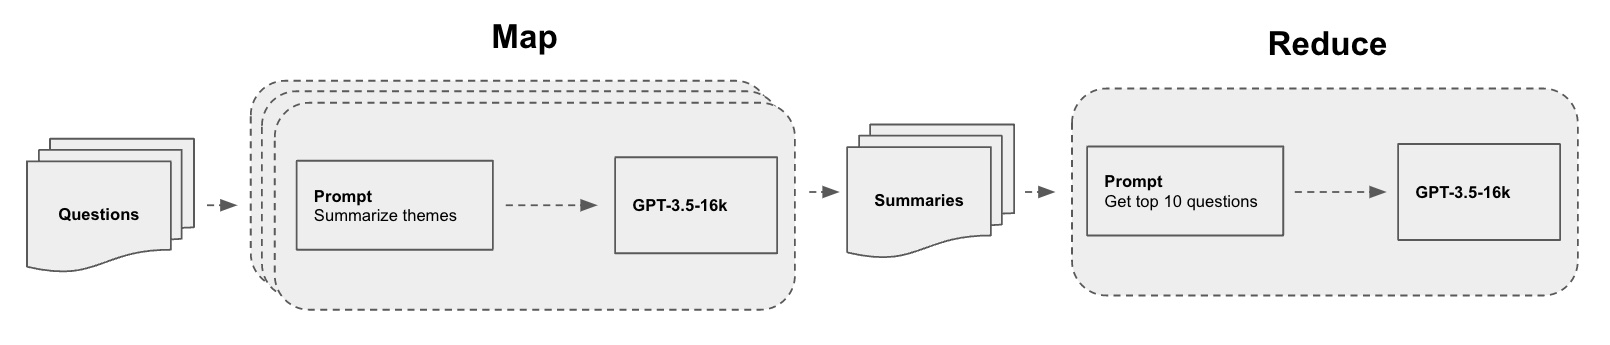

In [9]:
map_template_string = """The following is a list of questions, commands, and keyords that have been entered into a Q+A system
{questions}

Based on this list of questions, please do 3 things: 
(1) identify the main themes 
(2) give a represntitive example question in each theme
(3) estimate the proportion of questions that fall into each theme

Helpful Answer:"""

reduce_template_string = template = """The following is a list of summaries for questions entered into a Q+A system:
{question_summaries}

Take these and distill it into a final, consolidated list with: 
(1) the main question themes 
(2) two represntitive example questions in each theme
(3) estimate the proportion of questions that fall into each theme

Helpful Answer:"""
MAP_PROMPT = PromptTemplate(input_variables=["questions"], template=map_template_string)
REDUCE_PROMPT = PromptTemplate(input_variables=["question_summaries"], template=reduce_template_string)

### Map-Reduce chain

* See on documentation [here](https://python.langchain.com/docs/modules/chains/popular/summarize).
* Note: the splitter is not applied on Reduce stage; hit a token limit w/ GPT4.

In [20]:
def run_mr(input_doc,MAP_PROMPT,REDUCE_PROMPT):
    
    # Use `GPT3.5-Turbo-16k` for map
    llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)
    map_llm_chain = LLMChain(llm=llm, prompt=MAP_PROMPT)

    # llm = ChatOpenAI(model_name="gpt-3.5-turbo-16k", temperature=0)
    llm = ChatOpenAI(model_name="gpt-4", temperature=0)
    reduce_llm_chain = LLMChain(llm=llm, prompt=REDUCE_PROMPT)

    # Takes a list of documents and combines them into a single string
    combine_documents_chain = StuffDocumentsChain(
            llm_chain=reduce_llm_chain,
            document_variable_name="question_summaries")
    
    # Combines and iteravely reduces the mapped documents 
    reduce_documents_chain = ReduceDocumentsChain(
        # This is final chain that is called.
        combine_documents_chain=combine_documents_chain,
        # If documents exceed context for `combine_documents_chain`
        collapse_documents_chain=combine_documents_chain,
        # The maximum number of tokens to group documents into.
        token_max=4000)

    # Combining documents by mapping a chain over them, then combining results
    combine_documents = MapReduceDocumentsChain(
        # Map chain
        llm_chain=map_llm_chain,
        # Reduce chain
        reduce_documents_chain=reduce_documents_chain,
        # The variable name in the llm_chain to put the documents in
        document_variable_name="questions",
        # Return the results of the map steps in the output
        ### Bug: this currently does not work ###
        return_intermediate_steps=False)
        
    # Define Map=Reduce
    map_reduce = MapReduceChain(
        # Chain to combine documents
        combine_documents_chain=combine_documents,
        # Splitter to use for initial split
        text_splitter=text_splitter)
    
    return map_reduce.run(input_text=input_doc)

In [21]:
# Run 
result=run_mr(input_doc,MAP_PROMPT,REDUCE_PROMPT)

**(1) Main Question Themes:**

- **Langchain Usage and Implementation:**  
  Questions related to the basic usage, implementation, and understanding of Langchain and its components.
- **Agent and Chain Configuration:**  
  Queries about creating, customizing, and managing different types of agents and chains in Langchain.
- **Data Processing and Handling:**  
  Questions related to loading, processing, and manipulating different types of data and documents.
- **Integration with External Tools and Services:**  
  Queries about integrating Langchain with other APIs, services, platforms, and libraries.
- **Language Models and Embeddings:**  
  Questions about using and understanding different language models, creating vector embeddings, and document embedding.
- **Prompt Engineering and Customization:**  
  Queries about creating, customizing, and using prompt templates in Langchain.
- **Troubleshooting and Debugging:**  
  Questions related to handling errors, debugging code, and troubleshooting issues in Langchain.

**(2) Representative Example Questions:**

- **Langchain Usage and Implementation:**  
  - "How do I get started with Langchain on my PC?"  
  - "What are the system requirements for Langchain?"

- **Agent and Chain Configuration:**  
  - "What is the difference between a conversational retrieval chain and a retrieval QA chain?"  
  - "Can you explain the different types of agents in Langchain?"

- **Data Processing and Handling:**  
  - "How do I load data from my JSON results?"  
  - "Can Langchain handle large data sets?"

- **Integration with External Tools and Services:**  
  - "How can I connect Langchain with GCP BigQuery?"  
  - "Is Langchain compatible with AWS?"

- **Language Models and Embeddings:**  
  - "Are you smarter than GPT-3?"  
  - "How does Langchain utilize GPT-3?"

- **Prompt Engineering and Customization:**  
  - "How do I use a custom prompt template in Langchain?"  
  - "Can I create my own prompt templates?"

- **Troubleshooting and Debugging:**  
  - "I'm having trouble with your product. Can you help me troubleshoot?"  
  - "Do you offer technical support 24/7?"

**(3) Proportion of Questions:**

- Langchain Usage and Implementation: 20%
- Agent and Chain Configuration: 15%
- Data Processing and Handling: 15%
- Integration with External Tools and Services: 10%
- Language Models and Embeddings: 10%
- Prompt Engineering and Customization: 10%
- Troubleshooting and Debugging: 20%


# Deep Dive

We can also reduce to a specific set of questions on a given theme.

In [24]:
reduce_template_string = template = """The following is a list of summaries for questions entered into a Q+A system:
{question_summaries}

Take these and distill it into a final, consolidated list with: 
(1) the top 10 question related to loading, processing, and manipulating different types of data and documents.
(2) estimate the proportion of each question

Helpful Answer:"""
REDUCE_PROMPT = PromptTemplate(input_variables=["question_summaries"], template=reduce_template_string)

In [ ]:
# Run 
result=run_mr(input_doc,MAP_PROMPT,REDUCE_PROMPT)

**(1) Top 10 Questions Related to Loading, Processing, and Manipulating Different Types of Data and Documents:**

1. "How can I load a PDF file and split it into chunks using langchain?" - 15%
2. "How do I load and process a CSV file using Langchain?" - 12%
3. "How do I use the 'readfiletool' to load a text file?" - 11%
4. "How do I use Langchain to summarize a PDF document using the LLM model?" - 10%
5. "What are the different data loaders available in Langchain, and how do I choose the right one for my use case?" - 9%
6. "How do I load and process multiple PDFs?" - 9%
7. "How do I load all documents in a folder?" - 8%
8. "How do I split a string into a list of words in Python?" - 8%
9. "How do I load and process HTML content using BeautifulSoup?" - 8%
10. "How can I add metadata to the Pinecone upsert?" - 10%

**(2) Estimated Proportion of Each Question:**

1. "How can I load a PDF file and split it into chunks using langchain?" - 15%
2. "How do I load and process a CSV file using Langchain?" - 12%
3. "How do I use the 'readfiletool' to load a text file?" - 11%
4. "How do I use Langchain to summarize a PDF document using the LLM model?" - 10%
5. "What are the different data loaders available in Langchain, and how do I choose the right one for my use case?" - 9%
6. "How do I load and process multiple PDFs?" - 9%
7. "How do I load all documents in a folder?" - 8%
8. "How do I split a string into a list of words in Python?" - 8%
9. "How do I load and process HTML content using BeautifulSoup?" - 8%
10. "How can I add metadata to the Pinecone upsert?" - 10%

Please note that these proportions are estimates and may not be exact. The actual proportions can vary depending on the specific context and the number of questions related to each theme.